In [ ]:
from AssignmentQ2_Group5_B import * # Restart kernel if file changed
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from IPython.display import clear_output
clear_output(wait=True)
print('Success, obj:', model.ObjVal) if solved else print('Failed')

Success, obj: 376.98595739188215




Solution: [[(0, 20), (6, 0), (20, 6)], [(0, 5), (1, 9), (2, 1), (5, 2), (9, 11), (10, 0), (11, 10)], [(0, 3), (3, 7), (4, 0), (7, 4)], [(0, 14), (12, 0), (14, 15), (15, 16), (16, 12)], [(0, 17), (8, 0), (13, 18), (17, 13), (18, 19), (19, 8)]]


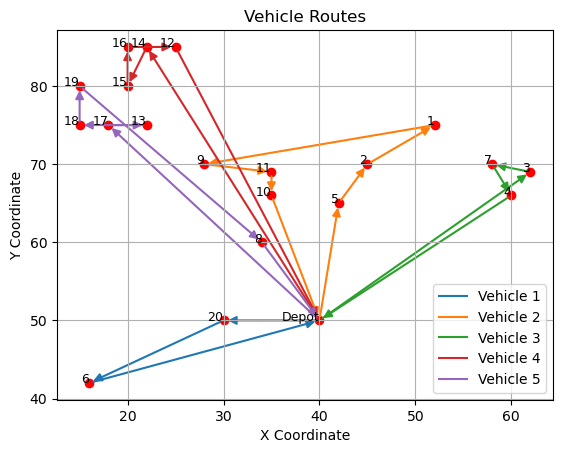

In [2]:
if solved:
    # Extract solution
    solution = []
    for v in V:
        route = []
        for i in N:
            for j in N:
                if x_ijv[i, j, v].X > 0.5:
                    route.append((i, j))
        solution.append(route)
    
    print('\n'*2, 'Solution: ', solution, sep='')

    # Plotting points
    x_coords = [node_data[0].XCOORD]
    y_coords = [node_data[0].YCOORD]
    for n in node_data[1:]:
        x_coords.append(n.XCOORD)
        y_coords.append(n.YCOORD)
    plt.scatter(x_coords, y_coords, color='red')
    plt.text(node_data[0].XCOORD, node_data[0].YCOORD, 'Depot', fontsize=9, ha='right')
    for i, n in enumerate(node_data[1:], start=1):
        plt.text(n.XCOORD, n.YCOORD, f'{i}', fontsize=9, ha='right')


    # Plotting the routes put arrows between the nodes
    cmap = plt.get_cmap('tab10')

    for v, route in enumerate(solution):
        if not route:
            continue
        color = cmap(v % 10)
        plt.plot([], [], color=color, label=f'Vehicle {v+1}')
        ax = plt.gca()
        for i_idx, j_idx in route:
            x1, y1 = node_data[i_idx].XCOORD, node_data[i_idx].YCOORD
            x2, y2 = node_data[j_idx].XCOORD, node_data[j_idx].YCOORD
            if x1 == x2 and y1 == y2:
                continue
            arr = FancyArrowPatch((x1, y1), (x2, y2),
                                 arrowstyle='-|>', mutation_scale=12,
                                 color=color, linewidth=1.5,
                                 shrinkA=3, shrinkB=3)
            ax.add_patch(arr)

    plt.title('Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid()
    plt.show()



Solution in sequence: [[0, 20, 6, 0], [0, 5, 2, 1, 9, 11, 10, 0], [0, 3, 7, 4, 0], [0, 14, 15, 16, 12, 0], [0, 17, 13, 18, 19, 8, 0]]
Node 0, Vehicle 0: Time Arrival=0, Charging Time=0, Waiting Time=0, Battery Level=110, After Charging=110, charging station=0 
Node 20, Vehicle 0: Time Arrival=20, Charging Time=0, Waiting Time=605, Battery Level=90, After Charging=90, charging station=0 
Node 6, Vehicle 0: Time Arrival=657, Charging Time=0, Waiting Time=732, Battery Level=58, After Charging=58, charging station=1 
Node 0, Vehicle 1: Time Arrival=0, Charging Time=0, Waiting Time=0, Battery Level=110, After Charging=110, charging station=0 
Node 5, Vehicle 1: Time Arrival=30, Charging Time=0, Waiting Time=90, Battery Level=80, After Charging=80, charging station=0 
Node 2, Vehicle 1: Time Arrival=213, Charging Time=0, Waiting Time=90, Battery Level=68, After Charging=68, charging station=0 
Node 1, Vehicle 1: Time Arrival=320, Charging Time=52, Waiting Time=38, Battery Level=51, After C

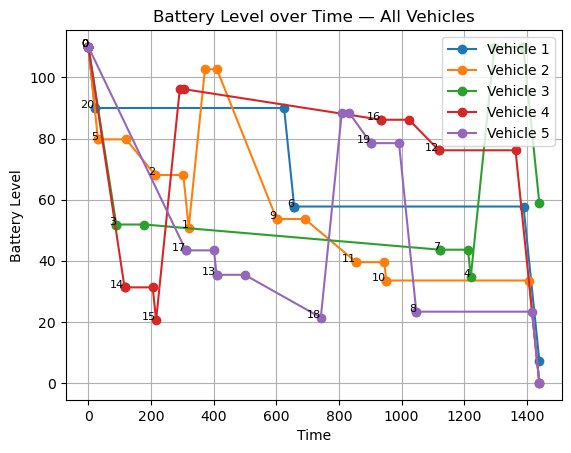



time of arrival: [0, 20, 657, 1440, 0, 30, 213, 320, 601, 855, 951, 1440, 0, 89, 1122, 1221, 1440, 0, 115, 216, 934, 1119, 1440, 0, 311, 409, 742, 902, 1047, 1440]


In [3]:

if solved:
    solution = []
    for v in V:
        route = [0]
        i = 0
        # follow arcs from the depot until we return to depot or no outgoing arc is found
        while True:
            found = False
            for j in N:  # iterate only over valid node indices
                if x_ijv[i, j, v].X > 0.5:
                    if route[-1] != j:
                        route.append(j)
                    i = j
                    found = True
                    break
            # stop if no outgoing arc or we've returned to the depot
            if not found or i == 0:
                break
        solution.append(route)
    
    print('\n'*2, 'Solution in sequence: ', solution, sep='')

    # time of arrival, charging time, waiting time, battery level




plt.figure()
cmap = plt.get_cmap('tab10')
timeofarrival = []
for vehicle, route in enumerate(solution):
    
    if not route:
        continue
    timeofarrival_v = []
    time = []
    battery = []
    for i in route[:-1]:  # Exclude the last node to avoid index error
        timeofarrival_v.append(round(tau_a_i[i].X))
        time.extend([
            tau_a_i[i].X,
            tau_a_i[i].X + tau_c_i[i].X,
            tau_a_i[i].X + tau_c_i[i].X + tau_w_i[i].X
        ])
        battery.extend([
            beta_iv[i, vehicle].X,
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i],
            beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i]
        ])
        print(f'Node {i}, Vehicle {round(vehicle)}: Time Arrival={round(tau_a_i[i].X)}, Charging Time={round(tau_c_i[i].X)}, Waiting Time={round(tau_w_i[i].X)}, Battery Level={round(beta_iv[i, vehicle].X)}, After Charging={round(beta_iv[i, vehicle].X + tau_c_i[i].X * bc * bs[i])}, charging station={bs[i]} ')
        plt.text(tau_a_i[i].X, beta_iv[i, vehicle].X, f'{i}', fontsize=8, ha='right')
        last_i = i
    timeofarrival_v.append(round(tau_a_i[last_i].X + tau_c_i[last_i].X    +     tau_w_i[last_i].X + d[last_i][0] * s))
    time.append(tau_a_i[last_i].X + tau_c_i[last_i].X    +     tau_w_i[last_i].X + d[last_i][0] * s)
    battery.append(beta_iv[last_i, vehicle].X     -    d[last_i][0] * s * bd  +  tau_c_i[last_i].X * bc * bs[last_i])
    timeofarrival.extend(timeofarrival_v)

    plt.plot(time, battery, marker='o', color=cmap(vehicle % 10), label=f'Vehicle {vehicle+1}')
plt.title(f'Battery Level over Time — All Vehicles')
plt.xlabel('Time')
plt.ylabel('Battery Level')
plt.legend()
plt.grid()
plt.show()

print('\n'*2,'time of arrival: ' , timeofarrival, sep='')





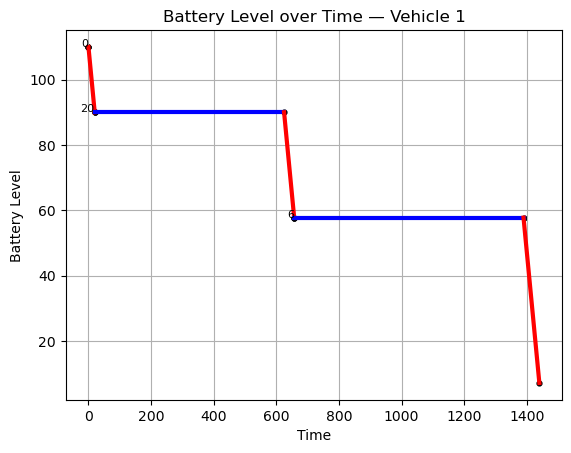

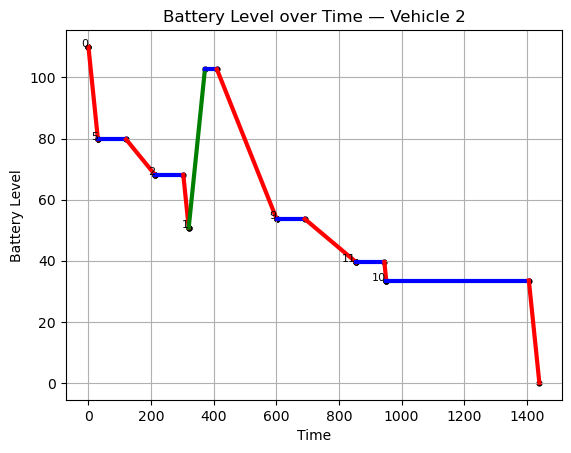

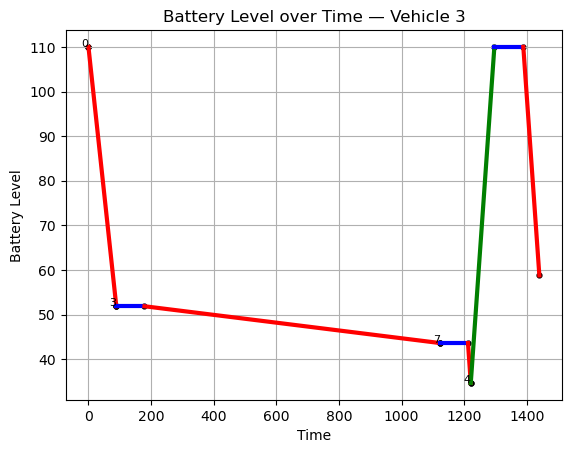

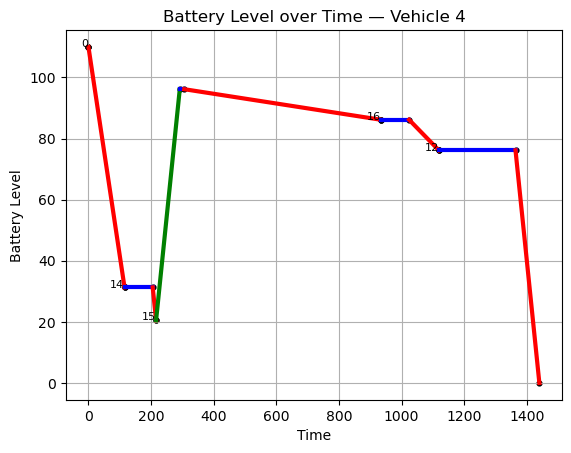

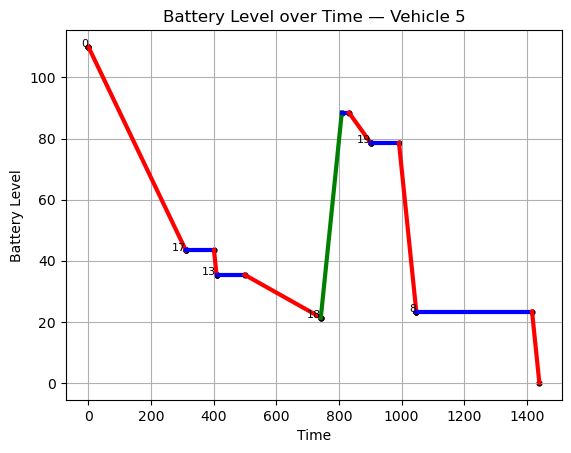

In [4]:
# plot per vehicle: charging (green), waiting (blue), discharging (red)
for vehicle, route in enumerate(solution):
    if not route:
        continue
    plt.figure()
    for idx in range(len(route) - 1):
        i = route[idx]
        j = route[idx + 1]

        # times
        t_arr = tau_a_i[i].X
        t_charge = tau_c_i[i].X
        t_wait = tau_w_i[i].X
        t_depart = t_arr + t_charge + t_wait

        # battery levels at i and after charging at i
        b_arr = beta_iv[i, vehicle].X
        b_after_ch = b_arr + t_charge * bc * bs[i]

        # if next node is depot (0) compute arrival time/battery from travel,
        # otherwise read from model variables
        if j == 0:
            t_arr_j = t_depart + d[i][0] * s
            b_arr_j = b_after_ch - d[i][0] * s * bd
        else:
            t_arr_j = tau_a_i[j].X
            b_arr_j = beta_iv[j, vehicle].X

        # charging segment (ramp up)
        if t_charge > 0:
            plt.plot([t_arr, t_arr + t_charge], [b_arr, b_after_ch], color='green', linewidth=3, label='Charging' if idx == 0 else "")
        # waiting segment (flat)
        if t_wait > 0:
            plt.plot([t_arr + t_charge, t_depart], [b_after_ch, b_after_ch], color='blue', linewidth=3, label='Waiting' if idx == 0 else "")
        # discharging/travel segment (ramp down)
        if t_depart < t_arr_j:
            plt.plot([t_depart, t_arr_j], [b_after_ch, b_arr_j], color='red', linewidth=3, label='Discharging' if idx == 0 else "")

        # annotate key points
        pts_t = [t_arr, t_arr + t_charge, t_depart, t_arr_j]
        pts_b = [b_arr, b_after_ch, b_after_ch, b_arr_j]
        plt.scatter(pts_t, pts_b, color='k', s=12)
        plt.text(t_arr, b_arr, f'{i}', fontsize=8, ha='right')

    plt.title(f'Battery Level over Time — Vehicle {vehicle+1}')
    plt.xlabel('Time')
    plt.ylabel('Battery Level')
    plt.grid()
    plt.show()


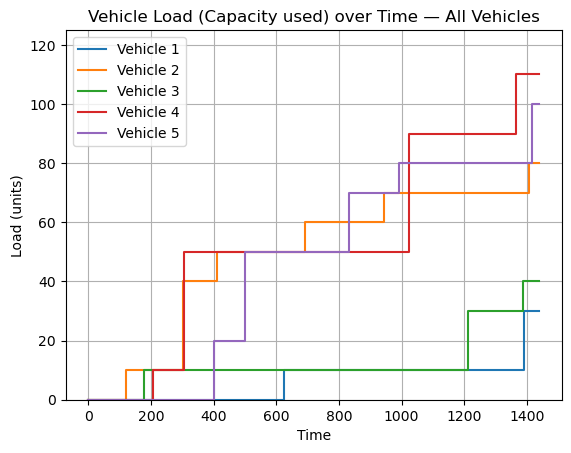

In [5]:
# plot of vehicle capacity (load) over time for all vehicles
# Override plt.step so subsequent calls plot "capacity used" instead of "capacity unused".
# The code below assumes 'loads' in the loop represent unused capacity (start at c and decrease).
_orig_step = plt.step
def _step_capacity_used(times, loads, where='post', **kwargs):
	used = [c - lv for lv in loads]  # convert unused -> used
	return _orig_step(times, used, where=where, **kwargs)
plt.step = _step_capacity_used
if solved:
	plt.figure()
	cmap = plt.get_cmap('tab10')

	for vehicle, route in enumerate(solution):
		if not route:
			continue

		times = []
		loads = []
		load = c  # start with full vehicle capacity

		# record initial depot arrival (usually time 0)
		start_node = route[0]
		t_start = tau_a_i[start_node].X
		times.append(t_start)
		loads.append(load)

		# iterate edges i -> j in the route
		for idx in range(len(route) - 1):
			i = route[idx]
			j = route[idx + 1]

			# times at node i
			t_arr_i = tau_a_i[i].X
			t_charge_i = tau_c_i[i].X
			t_wait_i = tau_w_i[i].X
			t_depart_i = t_arr_i + t_charge_i + t_wait_i

			# arrival at next node j (compute travel when j == 0)
			if j == 0:
				t_arr_j = t_depart_i + d[i][0] * s
			else:
				t_arr_j = tau_a_i[j].X

			# mark departure from i (load unchanged)
			times.append(t_depart_i)
			loads.append(load)

			# mark arrival at j (before unloading)
			times.append(t_arr_j)
			loads.append(load)

			# if j is a customer, unload (reduce load) after service at j
			if j != 0:
				t_after_service_j = t_arr_j + tau_c_i[j].X + tau_w_i[j].X
				new_load = max(0, load - q[j])  # cannot go below 0
				# keep load constant until end of service, then drop
				times.append(t_after_service_j)
				loads.append(new_load)
				load = new_load

		# ensure arrays are sorted in time (they should already be non-decreasing)
		# and plot as step function to show load changes over time
		plt.step(times, loads, where='post', color=cmap(vehicle % 10), label=f'Vehicle {vehicle+1}')

	plt.title('Vehicle Load (Capacity used) over Time — All Vehicles')
	plt.xlabel('Time')
	plt.ylabel('Load (units)')
	plt.ylim(0, c + 5)
	plt.grid(True)
	plt.legend()
	plt.show()
else:
	print("No solution to plot (res == 😢)")
